In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 150
DATA_PATH = "/kaggle/input/socofing/SOCOFing/Real/"
ALTER_EASY_PATH = "/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy/"

# Data Loading and Preprocessing
def load_fingerprint_data(data_path):
    images = []
    labels = []

    for filename in os.listdir(data_path):
        if filename.endswith(".BMP"):
            parts = filename.split('__')
            person_id = parts[0]
            finger_info = parts[1].split('_')
            hand = finger_info[1]
            finger_type = finger_info[2]
            label = f"{person_id}_{hand}_{finger_type}"

            img_path = os.path.join(data_path, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=IMG_SIZE)
            img = img_to_array(img).astype('float32') / 255.0
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    if images.ndim != 4:
        raise ValueError(f"Expected 4D array (num_samples, height, width, channels), got {images.shape}")

    return images, labels

# Load both datasets
images_real, labels_real = load_fingerprint_data(DATA_PATH)
images_alter_easy, labels_alter_easy = load_fingerprint_data(ALTER_EASY_PATH)
print(f"Loaded {len(images_real)} images from Real dataset")
print(f"Loaded {len(images_alter_easy)} images from Alter-Easy dataset")
print(f"Image shape: {images_real[0].shape}")

# Pair Generation
def create_pairs(images_real, labels_real, images_alter_easy, labels_alter_easy):
    label_to_real_image = {}
    for img, label in zip(images_real, labels_real):
        label_to_real_image[label] = img

    label_to_alter_images = {}
    for img, label in zip(images_alter_easy, labels_alter_easy):
        if label not in label_to_alter_images:
            label_to_alter_images[label] = []
        label_to_alter_images[label].append(img)

    # Generate positive pairs
    positive_pairs = []
    for label in label_to_real_image:
        if label in label_to_alter_images:
            real_img = label_to_real_image[label]
            for alter_img in label_to_alter_images[label]:
                positive_pairs.append([real_img, alter_img])

    # Generate negative pairs
    negative_pairs = []
    num_positive = len(positive_pairs)

    common_labels = list(set(label_to_real_image.keys()) & set(label_to_alter_images.keys()))

    while len(negative_pairs) < num_positive:
        label1 = random.choice(common_labels)
        label2 = random.choice(common_labels)
        if label1 != label2:
            real_img = label_to_real_image[label1]
            alter_img = random.choice(label_to_alter_images[label2])
            negative_pairs.append([real_img, alter_img])

    # Combine and shuffle pairs
    # 1- combine
    pairs = positive_pairs + negative_pairs
    pair_labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

    # 2- shuffle
    # Create a list of indices from 0 to len(pairs)-1
    indices = np.arange(len(pairs))
    # Randomly shuffle the indices
    np.random.shuffle(indices)
    # Shuffle pairs according to the shuffled indices
    pairs = np.array(pairs)[indices]
    # Shuffle labels the same way
    pair_labels = np.array(pair_labels)[indices]

    return pairs, pair_labels

pairs, labels = create_pairs(images_real, labels_real, images_alter_easy, labels_alter_easy)
print(f"Generated {len(pairs)} pairs")

# Train/Validation/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    pairs, labels, train_size=0.7, test_size=0.3, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, train_size=0.5, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training pairs: {len(X_train)}")
print(f"Validation pairs: {len(X_val)}")
print(f"Test pairs: {len(X_test)}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val)}")
print(f"Test class distribution: {np.bincount(y_test)}")


2025-05-05 22:28:18.180481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746484098.202392     436 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746484098.209488     436 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loaded 6000 images from Real dataset
Loaded 17931 images from Alter-Easy dataset
Image shape: (128, 128, 1)


I0000 00:00:1746484151.365380     436 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Generated 35862 pairs
Training pairs: 25103
Validation pairs: 5379
Test pairs: 5380
Training class distribution: [12551 12552]
Validation class distribution: [2690 2689]
Test class distribution: [2690 2690]


In [ ]:

# Siamese Network Architecture
def create_embedding_network(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(256, activation=None)(x)

    return Model(inputs, x)

def build_siamese_model(input_shape):
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    embedding_network = create_embedding_network(input_shape)

    embedding_a = embedding_network(input_a)
    embedding_b = embedding_network(input_b)

    distance = layers.Lambda(
        lambda embeddings: tf.abs(embeddings[0] - embeddings[1])
    )([embedding_a, embedding_b])

    output = layers.Dense(1, activation='sigmoid')(distance)

    return Model(inputs=[input_a, input_b], outputs=output)

input_shape = IMG_SIZE + (1,)
siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

# Compile the model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 256)            │      1,769,600 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256)            │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            257 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,769,857 (6.75 MB)

 Trainable params: 1,767,873 (6.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/150


I0000 00:00:1746484172.874423     468 service.cc:148] XLA service 0x7a4e8c01d990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746484172.874825     468 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746484173.625019     468 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/785 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.5496 - loss: 10.5390  

I0000 00:00:1746484179.288907     468 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


785/785 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.8686 - loss: 3.8498 - val_accuracy: 0.7747 - val_loss: 0.7871 - learning_rate: 0.0010
Epoch 2/150
785/785 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9237 - loss: 0.5956 - val_accuracy: 0.8991 - val_loss: 0.7238 - learning_rate: 0.0010
Epoch 3/150
785/785 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9330 - loss: 0.5545 - val_accuracy: 0.8241 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 4/150
785/785 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9287 - loss: 0.6490 - val_accuracy: 0.7816 - val_loss: 0.9169 - learning_rate: 0.0010
Epoch 5/150
785/785 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9281 - loss: 0.6106 - val_accuracy: 0.9214 - val_loss: 0.6560 - learning_rate: 0.0010
Epoch 6/150
785/785 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9429 - loss: 0.4909 - val_accuracy: 0.9201 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 7/150
785/785 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9481 - loss: 

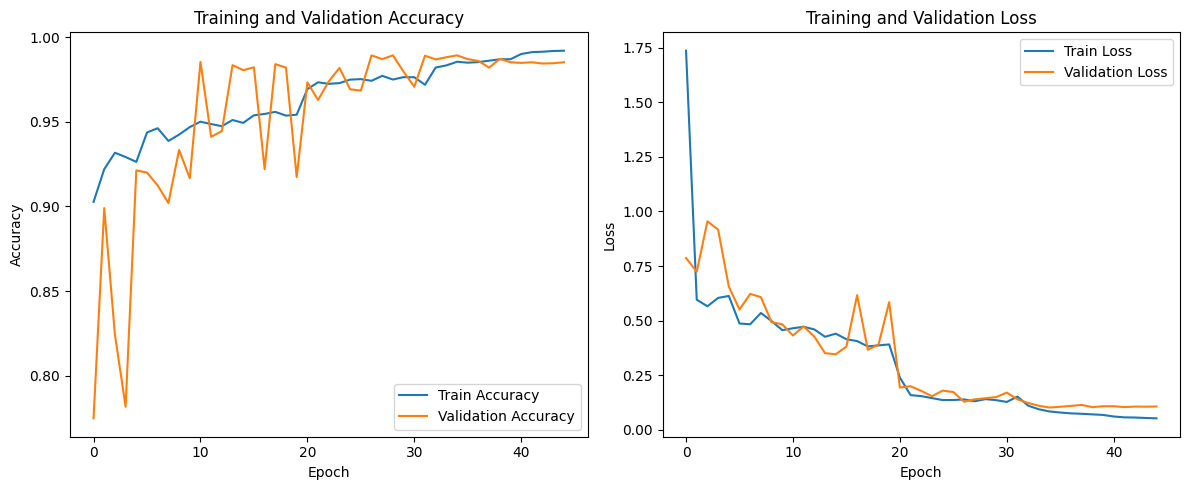

Training Evaluation:


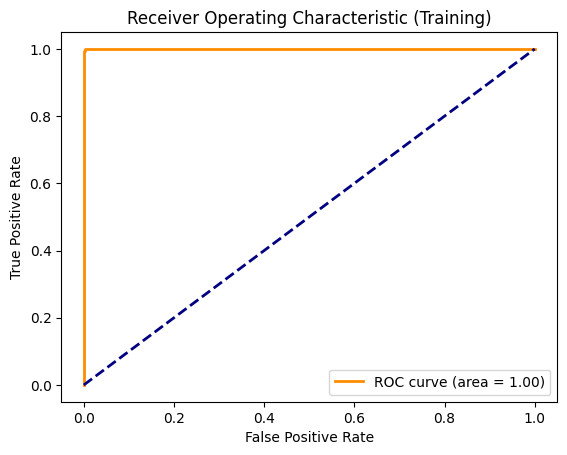


Validation Evaluation:


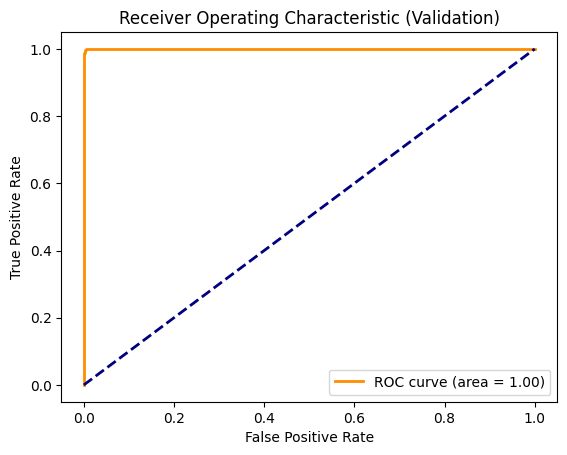


Test Evaluation:


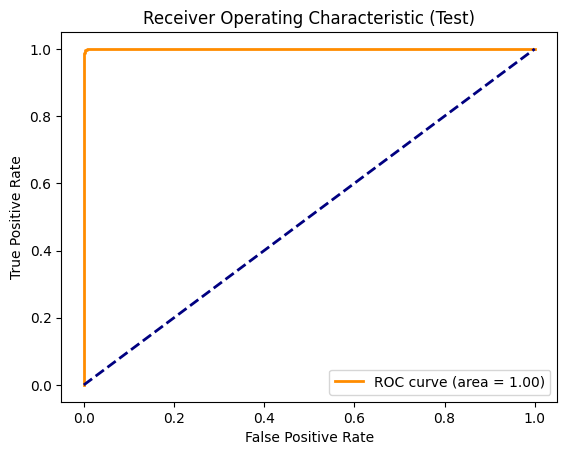

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9928 - loss: 0.0991

Final Metrics:
Training Accuracy: 0.9922 | AUC: 1.0000
Validation Accuracy: 0.9853 | AUC: 0.9999
Test Accuracy: 0.9913 | AUC: 0.9999
Sample Test Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


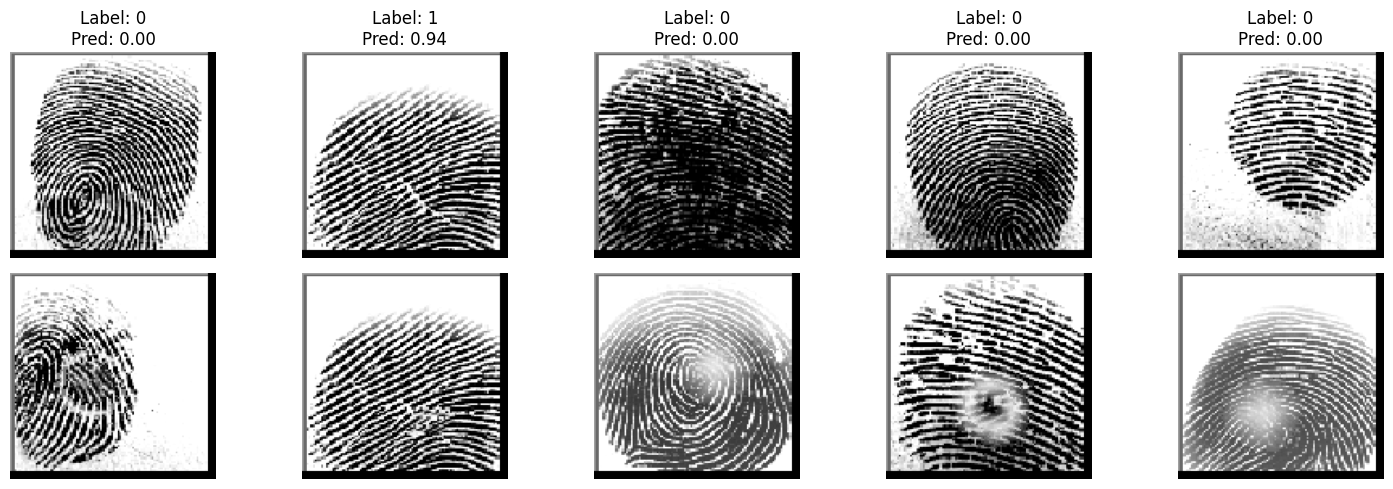

In [ ]:

history = siamese_model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

K.clear_session()
tf.compat.v1.reset_default_graph()

# Training Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png')
plt.show()

# Model Evaluation
def evaluate_model(model, X, y, set_name=''):
    batch_size = 8
    y_pred = []
    for i in range(0, len(X), batch_size):
        batch_X = X[i:i + batch_size]
        batch_pred = model.predict([batch_X[:, 0], batch_X[:, 1]], batch_size=batch_size, verbose=0)
        y_pred.extend(batch_pred)
    y_pred = np.array(y_pred)
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic ({set_name})')
    plt.legend(loc="lower right")
    plt.savefig(f'/kaggle/working/roc_curve_{set_name.lower()}.png')
    plt.show()

    return roc_auc

print("Training Evaluation:")
train_auc = evaluate_model(siamese_model, X_train, y_train, 'Training')

print("\nValidation Evaluation:")
val_auc = evaluate_model(siamese_model, X_val, y_val, 'Validation')

print("\nTest Evaluation:")
test_auc = evaluate_model(siamese_model, X_test, y_test, 'Test')

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_acc = siamese_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)[1]

print(f"\nFinal Metrics:")
print(f"Training Accuracy: {train_acc:.4f} | AUC: {train_auc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f} | AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Real Photo Evaluation
def visualize_predictions(model, X, y, num_samples=5):
    indices = np.random.choice(len(X), num_samples)
    sample_pairs = X[indices]
    sample_labels = y[indices]

    predictions = model.predict([sample_pairs[:, 0], sample_pairs[:, 1]])

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(sample_pairs[i][0].squeeze(), cmap='gray')
        plt.title(f"Label: {sample_labels[i]}\nPred: {predictions[i][0]:.2f}")
        plt.axis('off')

        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(sample_pairs[i][1].squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Sample Test Predictions:")
visualize_predictions(siamese_model, X_test, y_test)